# [--- Day 14: Disk Defragmentation ---](http://adventofcode.com/2017/day/14)

Suddenly, a scheduled job activates the system's disk defragmenter. Were the situation different, you might sit and watch it for a while, but today, you just don't have that kind of time. It's soaking up valuable system resources that are needed elsewhere, and so the only option is to help it finish its task as soon as possible.

The disk in question consists of a 128x128 grid; each square of the grid is either free or used. On this disk, the state of the grid is tracked by the bits in a sequence of knot hashes.

A total of 128 knot hashes are calculated, each corresponding to a single row in the grid; each hash contains 128 bits which correspond to individual grid squares. Each bit of a hash indicates whether that square is free (0) or used (1).

The hash inputs are a key string (your puzzle input), a dash, and a number from 0 to 127 corresponding to the row. For example, if your key string were flqrgnkx, then the first row would be given by the bits of the knot hash of flqrgnkx-0, the second row from the bits of the knot hash of flqrgnkx-1, and so on until the last row, flqrgnkx-127.

The output of a knot hash is traditionally represented by 32 hexadecimal digits; each of these digits correspond to 4 bits, for a total of 4 * 32 = 128 bits. To convert to bits, turn each hexadecimal digit to its equivalent binary value, high-bit first: 0 becomes 0000, 1 becomes 0001, e becomes 1110, f becomes 1111, and so on; a hash that begins with a0c2017... in hexadecimal would begin with 10100000110000100000000101110000... in binary.

Continuing this process, the first 8 rows and columns for key flqrgnkx appear as follows, using # to denote used squares, and . to denote free ones:

```
##.#.#..-->
.#.#.#.#   
....#.#.   
#.#.##.#   
.##.#...   
##..#..#   
.#...#..   
##.#.##.-->
|      |   
V      V   
```

In this example, 8108 squares are used across the entire 128x128 grid.

**Given your actual key string, how many squares are used?**

Your puzzle input is `ugkiagan`.

First up, since we need to make 128 knot hashes from the puzzle input:

In [2]:
puzzle_input = ["ugkiagan-" + str(i) for i in range(128)]
puzzle_input[:5], puzzle_input[-4:]

(['ugkiagan-0', 'ugkiagan-1', 'ugkiagan-2', 'ugkiagan-3', 'ugkiagan-4'],
 ['ugkiagan-124', 'ugkiagan-125', 'ugkiagan-126', 'ugkiagan-127'])

Now to actually knot dem hashes, so putting my somewhat messy code [from day 10](https://github.com/khalido/advent2017/blob/master/Day%2010%20-%20Knot%20Hash.ipynb) into one function:

In [19]:
from functools import reduce
import operator
import numpy as np

def knot_hash(key):
    """takes in a key and returns the knot hash """
    suffix = [int(i) for i in "17,31,73,47,23".split(",")]
    key_bytes = [ord(c) for c in key] + suffix

    string = [i for i in range(256)]

    skip_size = 0
    cur_pos = 0
    
    def make_substring_and_reverse(start_idx, length):
        """makes substring, reverses it, then returns full string"""
        if length > len(string):
            print("too long!")

        end_idx = start_idx + length
        if end_idx < len(string):
            return string[:start_idx] + string[start_idx:end_idx][::-1] + string[end_idx:]
        else:
            firstbit = string[start_idx:]

            wrap_pos = end_idx % len(string)
            secondbit = string[:(length-len(firstbit))]

            reverseString = (firstbit+secondbit)[::-1]

            # now to update the actual string
            temp_pos = cur_pos

            for char in reverseString:
                if temp_pos >= len(string):
                    temp_pos = 0
                string[temp_pos] = char
                temp_pos += 1

            return string
    
    for _ in range(64):
        for num in key_bytes:
            string = make_substring_and_reverse(cur_pos, num)
            # make cur_pos circular
            cur_pos += (num + skip_size)
            if cur_pos > len(string):
                cur_pos = cur_pos % len(string)
            skip_size += 1
    
    hash = []
    for i in range(0,256,16):
        h = reduce(operator.xor, string[i:i+16])
        hash.append(h)
    
    final_hash = [f"{c:02x}" for c in hash]
    final_hash = "".join(final_hash)
    return final_hash
    
    
assert knot_hash("") == "a2582a3a0e66e6e86e3812dcb672a272"
assert knot_hash("AoC 2017") == "33efeb34ea91902bb2f59c9920caa6cd"
assert knot_hash("1,2,3") == "3efbe78a8d82f29979031a4aa0b16a9d"
assert knot_hash("1,2,4") == "63960835bcdc130f0b66d7ff4f6a5a8e"
assert knot_hash("129,154,49,198,200,133,97,254,41,6,2,1,255,0,191,108") == "62e2204d2ca4f4924f6e7a80f1288786"

the above gives us the knot hash in hex, but we need a binary version:

In [24]:
def binary_hash(key):
    """returns the binary knot hash key of a string"""
    return bin(int(knot_hash(key), 16))[2:].zfill(128)

binary_hash("ugkiagan-0")

'00111111101000100111011010101111010111111111110110100111111111010110111100101110000110110100011001111010001011010111001010000101'

now to test this:

In [79]:
test_input = ["flqrgnkx-" + str(i) for i in range(128)]
test_input[:5], puzzle_input[-4:]

(['flqrgnkx-0', 'flqrgnkx-1', 'flqrgnkx-2', 'flqrgnkx-3', 'flqrgnkx-4'],
 ['ugkiagan-124', 'ugkiagan-125', 'ugkiagan-126', 'ugkiagan-127'])

I'm just counting the ones in the simplest possible manner, though there has to be a much faster numpy way of doing this:

In [23]:
def squares_used(key_string):
    grid = [binary_hash(k) for k in key_string]
    used = 0
    for h in grid:
        used += h.count("1")
    return used

print(squares_used(test_input))
squares_used(puzzle_input)

8108


8292

Eureka, `8292` is the right answer!

# --- Part Two ---

Now, all the defragmenter needs to know is the number of regions. A region is a group of used squares that are all adjacent, not including diagonals. Every used square is in exactly one region: lone used squares form their own isolated regions, while several adjacent squares all count as a single region.

In the example above, the following nine regions are visible, each marked with a distinct digit:

```
11.2.3..-->
.1.2.3.4   
....5.6.   
7.8.55.9   
.88.5...   
88..5..8   
.8...8..   
88.8.88.-->
|      |   
V      V   
```

Of particular interest is the region marked 8; while it does not appear contiguous in this small view, all of the squares marked 8 are connected when considering the whole 128x128 grid. In total, in this example, 1242 regions are present.

**How many regions are present given your key string?**

In [236]:
# the viz stuff
%matplotlib inline
import matplotlib.pyplot as plt # mpl is the base of all python plotting angst
import seaborn as sns # put some trainer wheels & lipstick on mpl

def visualize_squares_used(key_string):
    """takes in a list of strings and returns the binary knot hash in a list of lists"""
    grid = [[int(i) for i in binary_hash(k)] for k in key_string]
    return grid

disk = visualize_squares_used(puzzle_input)
disk[0][:16]

[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]

So that gives us the disk, now to visualize it we can think of it as an image 128x128:

So all the contigious 1's represent one region, so lets count the regions in the test_input first, which we know to have `1242` regions:

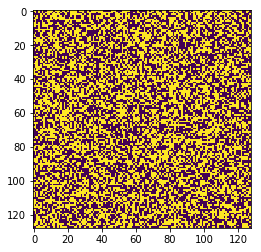

In [158]:
test_disk = visualize_squares_used(test_input)
plt.imshow(test_disk, interpolation=None);

this is a [flood fill problem](https://en.wikipedia.org/wiki/Flood_fill), so implementing a simple resursive solution:

In [117]:
#fill = visualize_squares_used(test_input)

def flood_fill(x, y, old, new):
    """takes in a x,y position from where to flood fill, the old val to change from and the new val
    to change too, and then does so on a to_fill array"""
    
    if fill[x][y] != old or fill[x][y] == new:
        return
    
    fill[x][y] = new
    
    max_x = len(fill) - 1
    max_y = len(fill) - 1
    
    if x > 0: # go left
        flood_fill(x-1, y, old, new)
    
    if x < max_x: # go right
        flood_fill(x+1, y, old, new)
        
    if y > 0: # go down
        flood_fill(x, y-1, old, new)
    if y < max_y: # go up
        flood_fill(x, y+1, old, new)

In [118]:
fill = visualize_squares_used(test_input)
count = 0

for i in range(len(fill)):
    for j in range(len(fill[0])):
        if fill[i][j] == 1:
            flood_fill(i, j, 1, 8)
            count += 1
            
count

1242

So that gives us the correct answer `1242` for the test input, now to check the puzzle input:

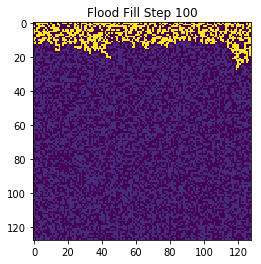

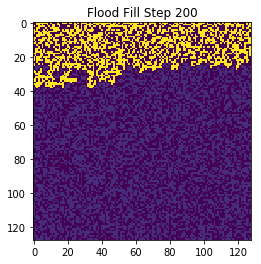

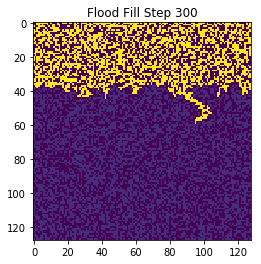

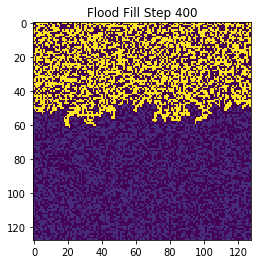

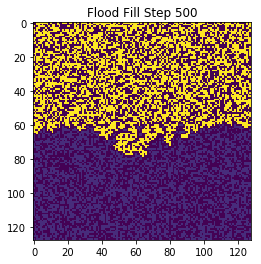

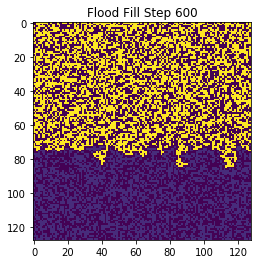

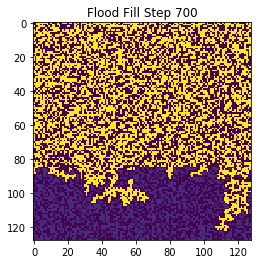

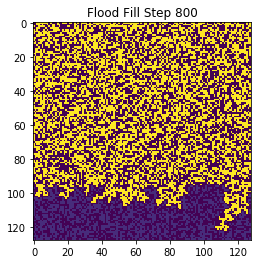

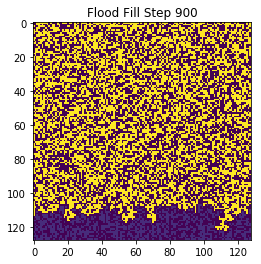

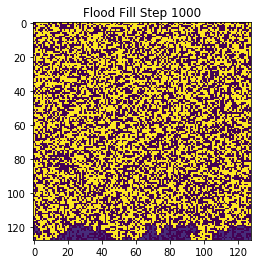

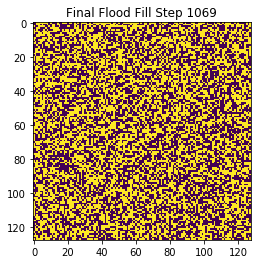

In [214]:
fill = visualize_squares_used(puzzle_input)
count = 0

for i in range(len(fill)):
    for j in range(len(fill[0])):
        if fill[i][j] == 1:
            flood_fill(i, j, 1, 8)
            count += 1
            if count % 100 == 0:
                plt.imshow(fill)
                plt.title(f"Flood Fill Step {count}")
                plt.show()
            
plt.imshow(fill)
plt.title(f"Final Flood Fill Step {count}")
plt.show()

So we got `1069`, which is the right answer for part 2. for bonus points, I want to visulize the flood fill as it happens:

## animated flood fill

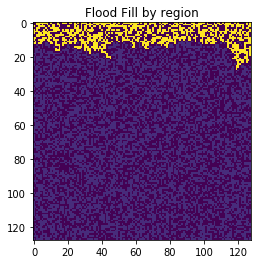

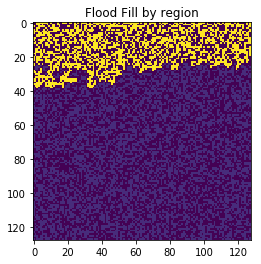

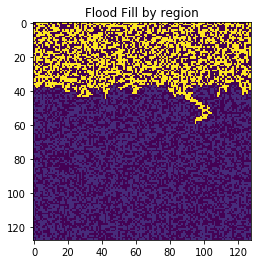

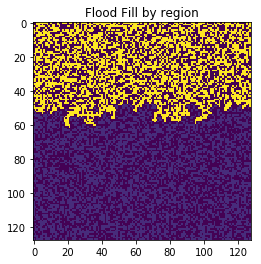

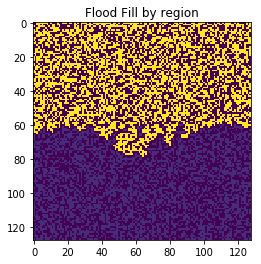

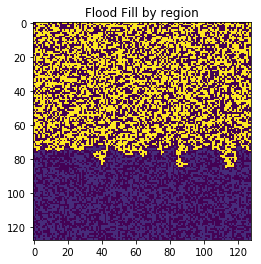

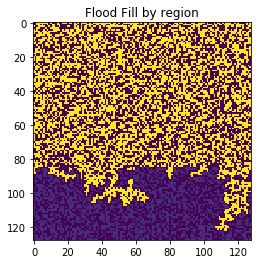

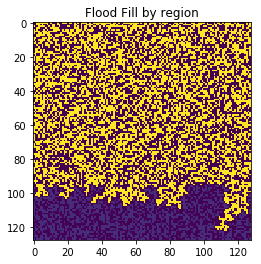

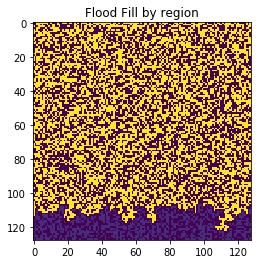

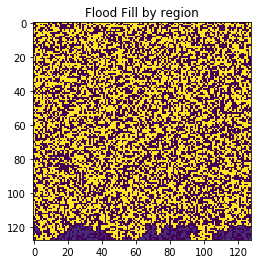

1069

In [237]:
fill = visualize_squares_used(puzzle_input)
count = 0

imagelist = list()
imagelist.append(fill)

for i in range(len(fill)):
    for j in range(len(fill[0])):
        if fill[i][j] == 1:
            flood_fill(i, j, 1, 8)
            count += 1
            imagelist.append(fill)
            if count % 100 == 0:
                plt.imshow(imagelist[count])
                plt.title("Flood Fill by region")
                plt.show()
                
count

So now we have a list of all the disk states as it flood fills:

In [255]:
np.random.randint(0,100, (3,3))

array([[13, 13, 79],
       [38, 12, 14],
       [17, 40,  5]])

In [273]:
import numpy as np
imagelist = [np.random.randint(0,50,(128,128)) for _ in range(100)]

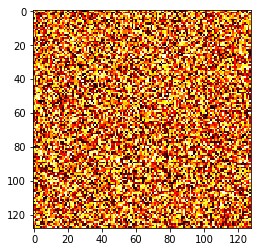

In [275]:
%matplotlib inline
plt.imshow(imagelist[0], cmap='hot')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: outfile must be *.htm or *.html

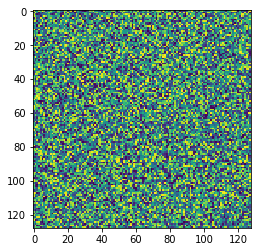

In [277]:
fig = plt.figure() # make figure

# make axesimage object

im = plt.imshow(imagelist[0], animated=True)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(imagelist[j])
    # return the artists set
    return [im]

# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(20), 
                              interval=150, blit=True)

ani.save("disk.mp4")
plt.show()

In [233]:
len(steps)

1070